In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from traj_utils import *
import matplotlib.pyplot as plt
from viz_utils import *

/home/beans/bespoke/constants.py:448: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  propref_aux_target['ixx'] = list(range(len(propref_aux_target))) # dumb self ix so can grab sigmoid from within this smaller df


In [2]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [3]:
aux, targets, run_paths = [], [], []
n_couldnt_load_runs = 0

for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            print(run_path)
            n_couldnt_load_runs += 1
            continue
            
        _aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        _targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        aux.append(_aux)
        targets.append(_targets)
        run_paths.append(run_path)
        
aux = na(np.stack(aux, axis=0), AUX_PROPS)
targets = np.stack(targets, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 0 out of 1536 runs


In [4]:
all_wp_angles, all_wp_dists, all_wp_rolls, all_wp_zs = np.split(targets, 4, axis=-1)

In [5]:
%%time
speed_mask = get_speed_mask(aux[:,:,'speed'])
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)
all_curvatures = get_curvatures_from_headings_batch(all_headings)

CPU times: user 37.6 s, sys: 4.6 ms, total: 37.6 s
Wall time: 37.6 s


In [6]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape, speed_mask.shape

((1536, 1280, 30),
 (1536, 1280, 30),
 (1536, 1280, 30),
 (1536, 1280, 30),
 (1536, 1280, 30))

In [7]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .1:
        print(i, m)
        mm += 1

495 0.11720556


In [8]:
run_paths[2]

'/home/beans/blender_membank/dataloader_00/run_2'

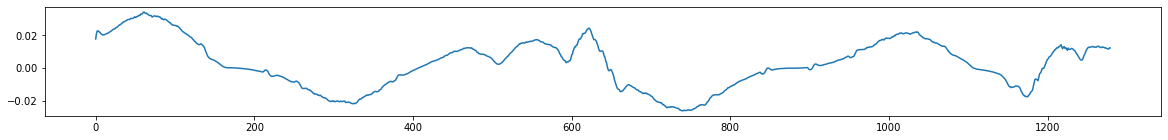

In [9]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[2,:,0])

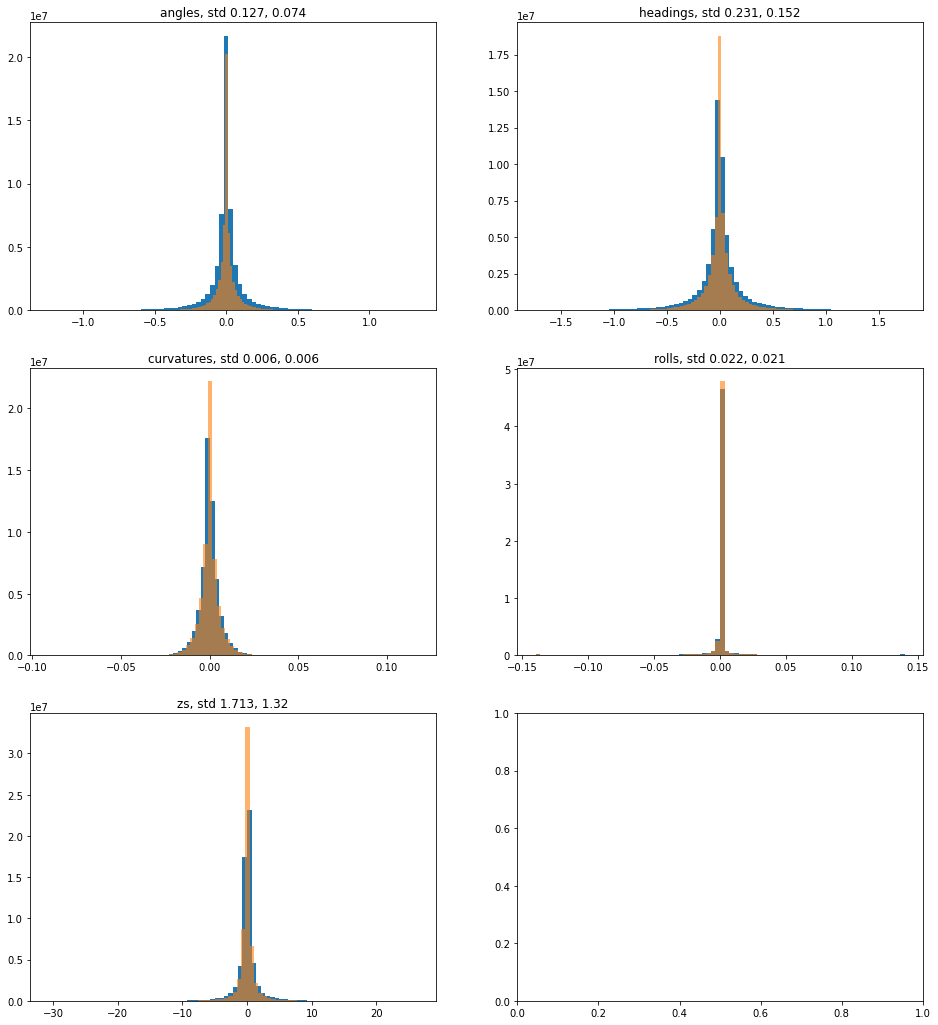

In [10]:
ws = [all_wp_angles, all_headings, all_curvatures, all_wp_rolls, all_wp_zs]
plot_wps(ws, speed_mask)

In [11]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02666146, 0.03093213, 0.03504223, 0.03914979, 0.04325188,
       0.0473464 , 0.05143021, 0.05550233, 0.05956057, 0.06360222,
       0.0676262 , 0.07163209, 0.07561918, 0.07958741, 0.08353616,
       0.08746425, 0.09137142, 0.09525779, 0.09912322, 0.10289018,
       0.13935235, 0.17411497, 0.20620504, 0.23547712, 0.26208106,
       0.28622475, 0.3081155 , 0.32797995, 0.346003  , 0.355143  ],
      dtype=float32)

In [12]:
mean_headings[-1] / mean_headings[0]

13.320463

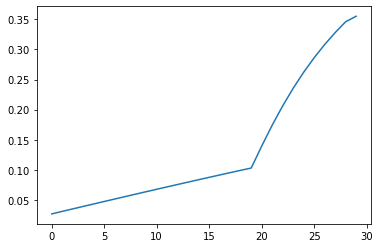

In [13]:
plt.plot(mean_headings)

In [14]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01068018, 0.01315365, 0.01558144, 0.01794601, 0.02025418,
       0.02251643, 0.02474157, 0.02693642, 0.02910581, 0.03125353,
       0.03338242, 0.03549441, 0.03759091, 0.03967339, 0.04174259,
       0.04379936, 0.0458443 , 0.04787789, 0.04990053, 0.05191257,
       0.07147194, 0.09006036, 0.10767689, 0.12427934, 0.13984153,
       0.15438743, 0.16796678, 0.18063734, 0.19245407, 0.20346853],
      dtype=float32)

In [15]:
mean_angles[-1] / mean_angles[0]

19.051039

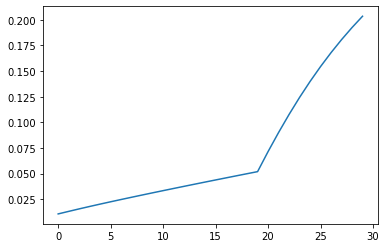

In [16]:
plt.plot(mean_angles)

In [17]:
all_wp_angles[:,:,0].std()

0.018776733

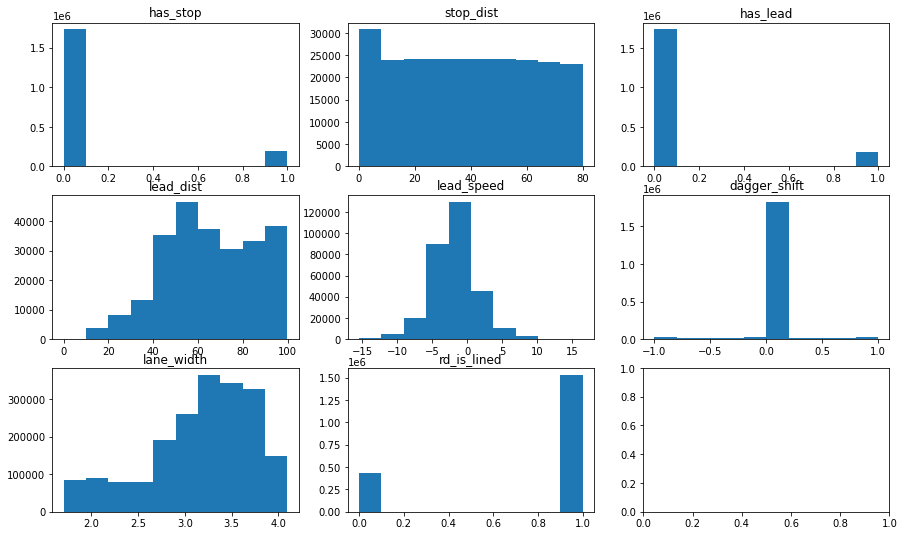

In [18]:
plot_aux(aux, AUX_TARGET_PROPS)

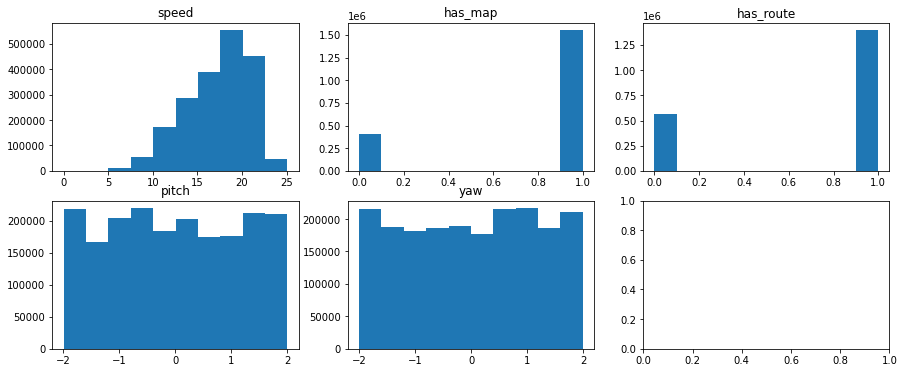

In [19]:
plot_aux(aux, AUX_MODEL_PROPS)

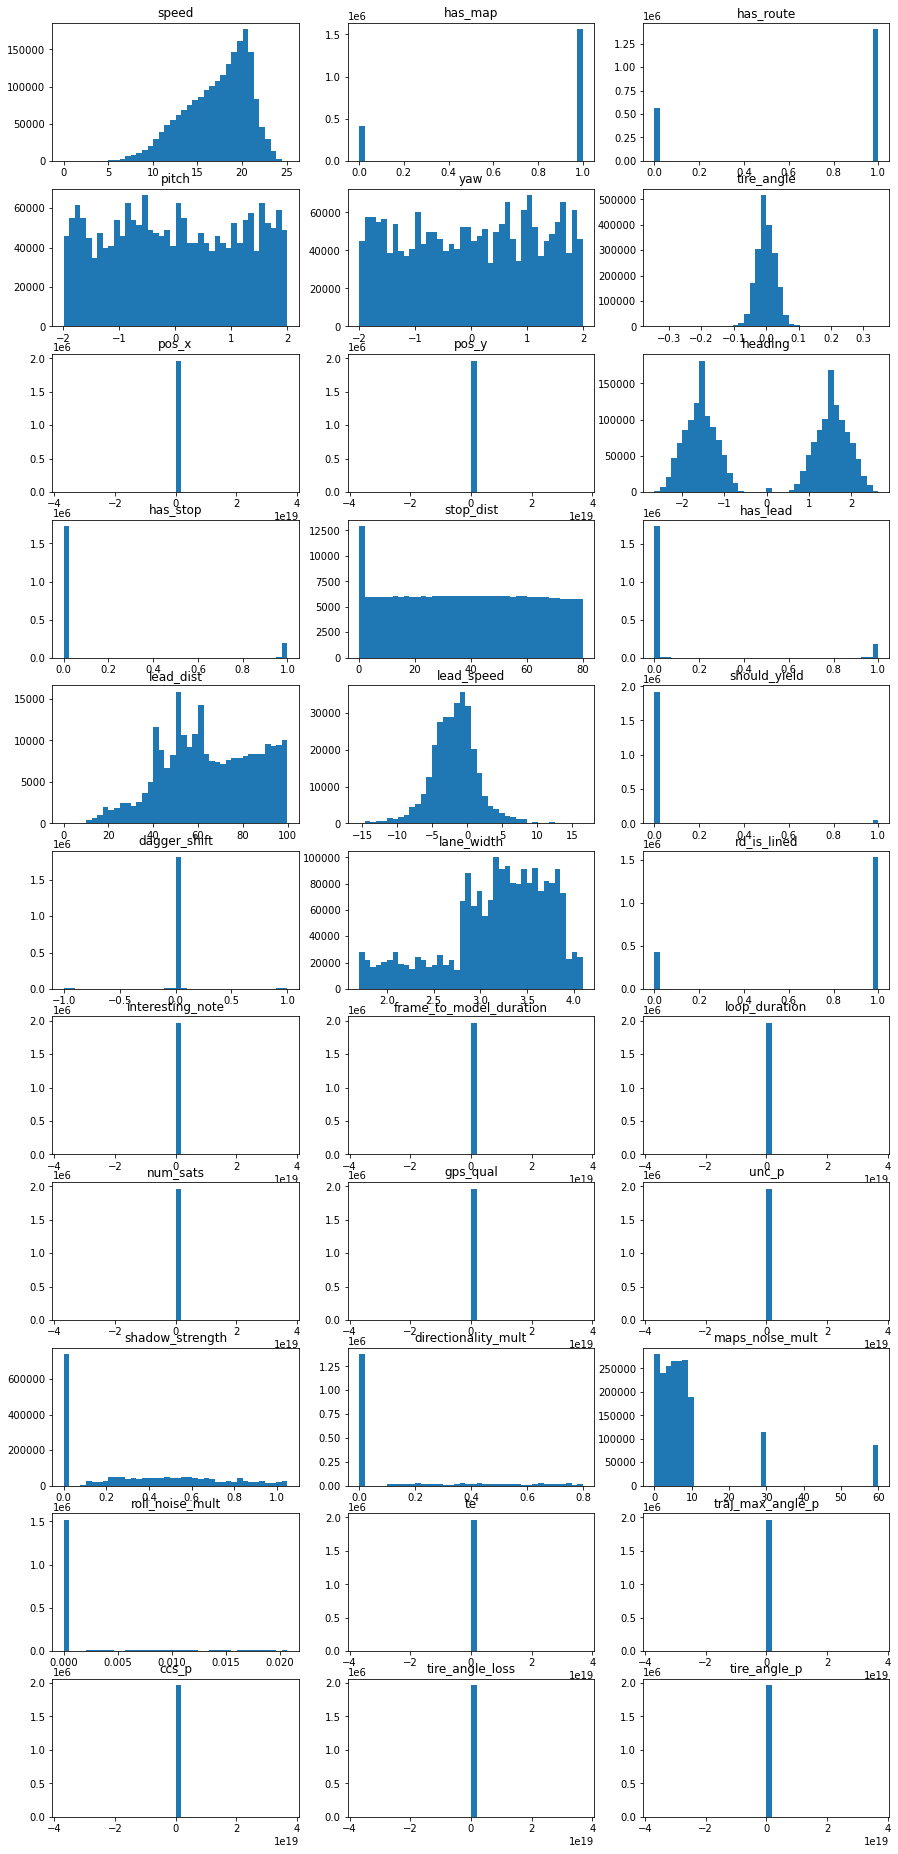

In [21]:
plot_aux(aux, AUX_PROPS)

In [27]:
np.quantile(abs(aux[:,:,"tire_angle"]), .999)

0.13738369163871467